# Train a network to detect and classify prairie dog warning barks.
## Train for class based on geography
### pdc5_train - prairie dog 5 class training notebook

In [25]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# need this for confusion plots
import seaborn as sns
from keras.utils import plot_model
# use scipy for STFT on the inference side: not used in training
# except to match spectrogram sizes between training and inference
from scipy import signal

from tensorflow.keras import layers
from tensorflow.keras import models

# use a fixed seed for run-to-run repeatability
rand_seed = 42
batch_size = 64

### Define some signal processing and visualization functions.

In [26]:
# This yields a spectrogram of size 517x513
def get_spectrogram0(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  #spectrogram = tf.signal.stft(
  #    waveform, frame_length=255, frame_step=1024)
  spectrogram = tf.signal.stft(
      waveform, frame_length=513, frame_step=256, pad_end=True)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

# scipy version to match inference
# during testing and calibfration, a fudge factor was introduced to help
# match scaling between spectrograms
# tuned to get a 517x513 spectrogram mathcing tf's STFT
def get_spectrogram1(waveform):
  ff = 0.7
  # Convert the waveform to a spectrogram via a STFT.
  #spectrogram = tf.signal.stft(
  #    waveform, frame_length=255, frame_step=1024)
  _, _, spectrogram = signal.stft(
      waveform, nperseg=1024, noverlap=768)
  win = signal.get_window('hann', 1024)
  scale = np.sqrt(1.0 / win.sum()**2)
  #print(type(spectrogram))
  # Obtain the magnitude of the STFT.
  spectrogram = ff*np.absolute(spectrogram.transpose())/scale  
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  #spectrogram = spectrogram[::8,:]
  spectrogram = spectrogram[:-1,:]
  spectrogram = spectrogram[..., np.newaxis]
  #spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)
  #print(type(spectrogram))
  return spectrogram
        
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def make_plots(waveform,str,fname):
    spectrogram = get_spectrogram0(waveform)
    fig,axes = plt.subplots(2,figsize=(12,13))
    timescale = np.arange(waveform.shape[0])
    axes[0].plot(timescale, waveform.numpy())
    axes[0].set_title('Time Series '+str)
    axes[0].set_xlim([0, len(waveform)])
    axes[0].set_xlabel('Time (s)')
    plot_spectrogram(spectrogram.numpy(), axes[1])
    axes[1].set_title('Spectrogram '+str)
    axes[1].set_xlabel('Sample')
    #plt.savefig(fname, bbox_inches='tight')
    plt.show()

def make_two_plots(waveform,str,fname):
    spectrogram0 = get_spectrogram0(waveform)
    spectrogram1 = get_spectrogram1(waveform)
    fig,axes = plt.subplots(2,figsize=(12,13))
    plot_spectrogram(spectrogram0.numpy(), axes[0])
    axes[0].set_title('Spectrogram0 '+str)
    axes[0].set_xlabel('Sample')
    plot_spectrogram(spectrogram1.numpy(), axes[1])
    axes[1].set_title('Spectrogram1 '+str)
    axes[1].set_xlabel('Sample')
#plt.savefig(fname, bbox_inches='tight')
    plt.show()

## Load the data
### There is a directory for each class: prairie dogs and Other
### The JF (Jasper Farms) directory was added after data collected in the field was added

In [27]:
data_dir = "C:\\Users\\fredp\\pywork\\ECE528\\Final Project\\All data"
#dataset = keras.utils.audio_dataset_from_directory(main_directory, labels='inferred')

train_ds, val_ds = keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=batch_size,
    validation_split=0.2,
    seed=rand_seed,
    output_sequence_length=132300, # 3 s at 44.1 kHz sampling
    subset='both')

classes = np.array(train_ds.class_names)
print()
print("label names:", classes)

Found 698 files belonging to 5 classes.
Using 559 files for training.
Using 139 files for validation.

label names: ['JF' 'Other' 'PDCRE' 'PDPRE' 'PDTCE']


In [28]:
train_ds.element_spec

(TensorSpec(shape=(None, 132300, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [29]:
# force mono
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [30]:
test_ds = val_ds.shard(num_shards=2, index=0) # get a test set as well
val_ds = val_ds.shard(num_shards=2, index=1)

## Visualize the data

### Here we visualize one timeseries example for each of the two classes in the dataset.
### We derived the fudge factor for these data for amplitude matching between scipy's
### and tf's STFT

(64, 132300)
(64,)
spect0 :  [8.426486  3.6628404 9.719956  4.7472973 8.61874  ]
spect1 :  [6.321575 8.408117 8.163196 8.909811 8.7365  ]
spect0/spect1 : [1.3329725  0.43563145 1.1907048  0.5328168  0.98652095]
57.948524
61.16514
(517, 513, 1)
(517, 513, 1)
FF =  1.019888


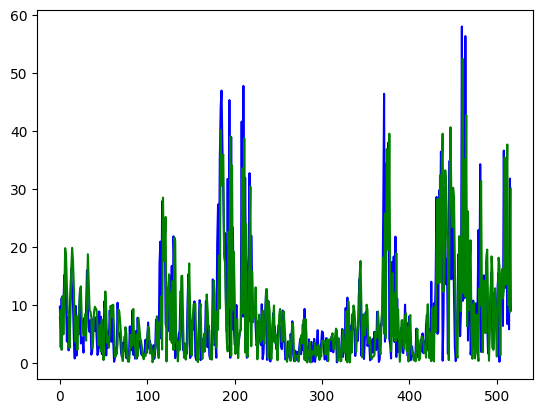

In [31]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

for i in range(batch_size):
    if classes[example_labels[i]] == 'PDCRE':
        ex0 = i
    else:
        if classes[example_labels[i]] == 'Other':
            ex1 = i
waveform1 = example_audio[ex0]
#make_plots(waveform1,classes[example_labels[ex0]],'samp0.png')
waveform = example_audio[ex1]
#make_plots(waveform,classes[example_labels[ex1]],'samp1.png')

# compare spectrograms between tf method (training)
# and scipy method (inference)
spect0 = get_spectrogram0(waveform1)
spect1 = get_spectrogram1(waveform1)
spect0 = spect0.numpy()
#spect1 = spect1.numpy()
print('spect0 : ',spect0[:5,1,0])
print('spect1 : ',spect1[:5,1,0])
print('spect0/spect1 :', spect0[:5,1,0]/spect1[:5,1,0])
print(spect0.max())
print(spect1.max())
print(spect0.shape)
print(spect1.shape)
print('FF = ',np.sum(spect0)/np.sum(spect1))
#x=range(129)
plt.plot(spect0[:,0,0],'b')
plt.plot(spect1[:,0,0],'g')
plt.show()
#make_two_plots(waveform1,'','')


In [32]:
# Create datasets from the spectrograms
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram0(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)
    
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Input shape: (517, 513, 1)
(517, 513, 1)
PDTCE
(517, 513, 1)
<class 'numpy.ndarray'>
(517, 513, 1)
265221
(517, 513, 1)
265221


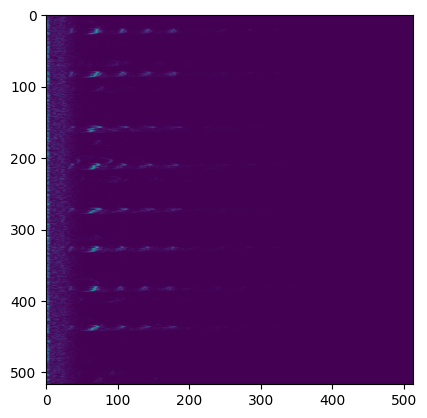

In [33]:
# This is just a play box for debug
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

input_shape=example_spectrograms.shape[1:]
print('Input shape:', input_shape)

print(example_spectrograms[0,:,:,:].shape)
examp1=example_spectrograms[6,:,:,:]
print(classes[example_spect_labels[6].numpy()])
print(examp1.shape)
print(type(examp1.numpy()))
npexamp1=examp1.numpy()
print(npexamp1.shape)
print(npexamp1.size)
#npexamp1=np.array(examp1,dtype=np.int8)
npexamp1=np.array(examp1)
print(npexamp1.shape)
print(npexamp1.size)
import matplotlib.pyplot as plt
plt.imshow(npexamp1) #Needs to be in row,col order
plt.savefig('npexamp1.png')
np.save('npexamp1.npy', npexamp1)
#print(npexamp1)



Other


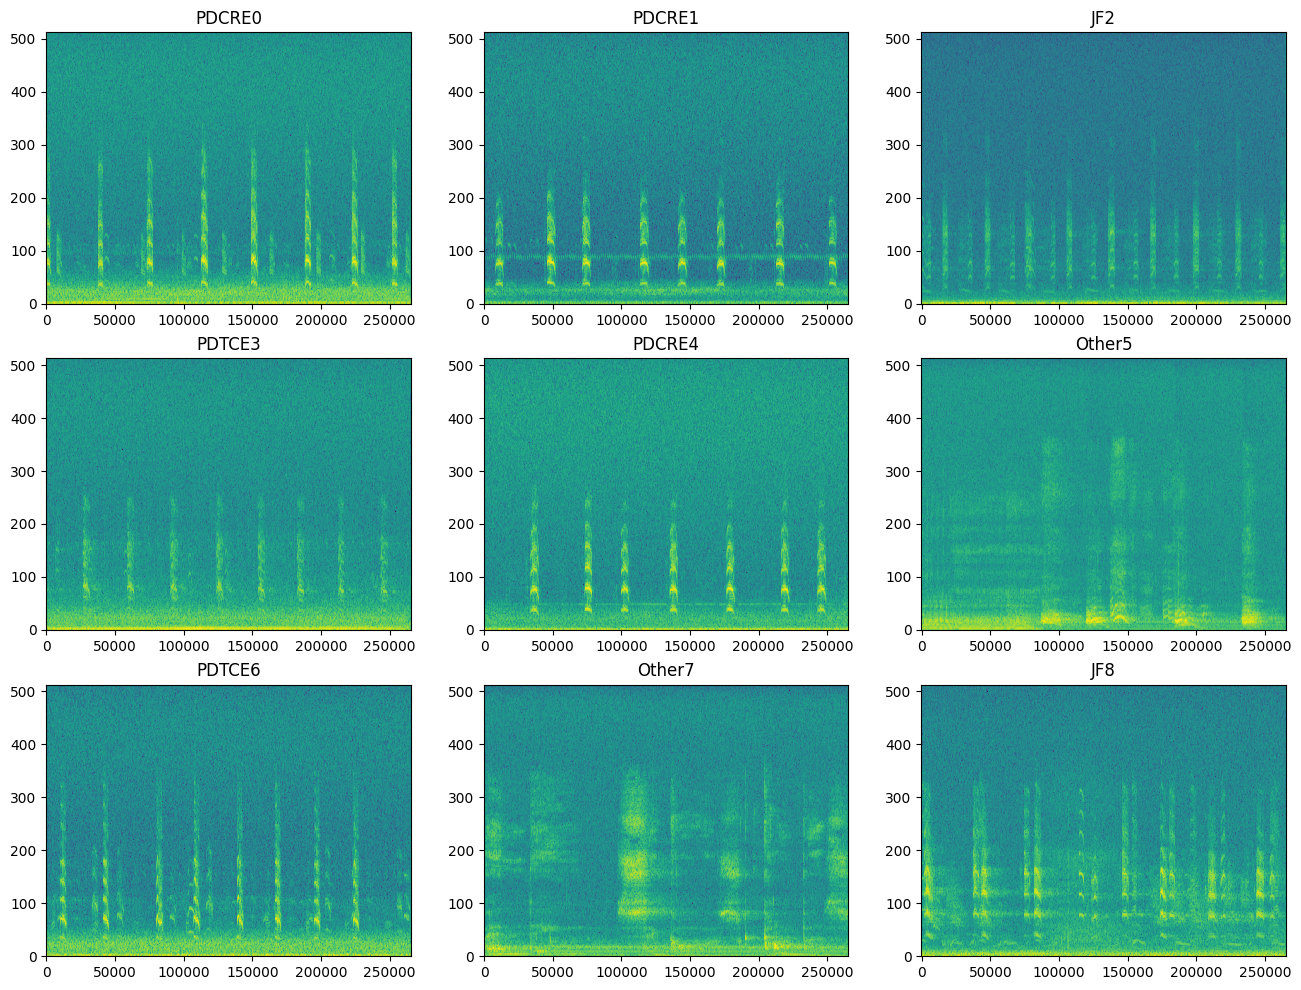

(517, 513, 1)


In [34]:
# Plot several example spectrograms
print(classes[example_spect_labels[5].numpy()])
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(classes[example_spect_labels[i].numpy()]+str(i))
    
#plt.savefig('specmat.png', bbox_inches='tight')
plt.show()

print(example_spectrograms[0].shape)

## Build and train the model
### This model was built up from the model given in the TensorFLow audio processing example
### given online.

In [35]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [36]:
#input_shape = example_spectrograms.shape[1:]
#print('Input shape:', input_shape)
#num_labels = len(classes)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(classes)
      
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(train_spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(128, 128),
    # Normalize.
    norm_layer,
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.6),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()
#plot_model(model, to_file='model.png')

Input shape: (517, 513, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 128, 128, 1)       0         
                                                                 
 normalization_1 (Normaliza  (None, 128, 128, 1)       3         
 tion)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [38]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
9/9 [==============================] - 11s 1s/step - loss: 1.6307 - accuracy: 0.2415 - val_loss: 1.5138 - val_accuracy: 0.3750
Epoch 2/50
9/9 [==============================] - 8s 888ms/step - loss: 1.5065 - accuracy: 0.3095 - val_loss: 1.3522 - val_accuracy: 0.3281
Epoch 3/50
9/9 [==============================] - 8s 854ms/step - loss: 1.3901 - accuracy: 0.3936 - val_loss: 1.2696 - val_accuracy: 0.5469
Epoch 4/50
9/9 [==============================] - 8s 913ms/step - loss: 1.2655 - accuracy: 0.4347 - val_loss: 1.1559 - val_accuracy: 0.6562
Epoch 5/50
9/9 [==============================] - 8s 877ms/step - loss: 1.1740 - accuracy: 0.4937 - val_loss: 1.0037 - val_accuracy: 0.6562
Epoch 6/50
9/9 [==============================] - 8s 869ms/step - loss: 1.1005 - accuracy: 0.5474 - val_loss: 0.9806 - val_accuracy: 0.7188
Epoch 7/50
9/9 [==============================] - 8s 882ms/step - loss: 1.0285 - accuracy: 0.6064 - val_loss: 0.8953 - val_accuracy: 0.6875
Epoch 8/50
9/9 [======

Text(0, 0.5, 'Accuracy [%]')

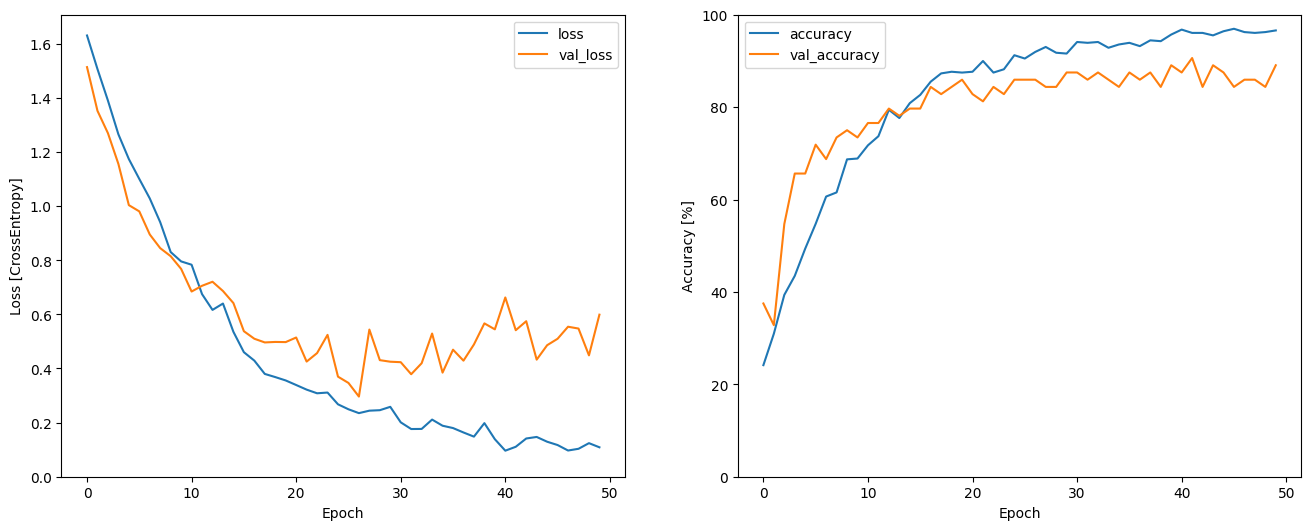

In [39]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
#plt.savefig('training.png', bbox_inches='tight')

## Model yields 97% accuracy

In [40]:
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 [==============================] - 1s 60ms/step - loss: 0.0624 - accuracy: 0.9733


{'loss': 0.06237506866455078, 'accuracy': 0.9733333587646484}

## Make some predictions

In [41]:
y_pred = model.predict(test_spectrogram_ds)

2/2 [==============================] - 0s 57ms/step


In [42]:
examp_pred = model.predict(train_spectrogram_ds.take(1))

1/1 [==============================] - 0s 288ms/step


In [43]:
#print(examp_pred)
# Print our model's predictions
print(np.argmax(examp_pred, axis=1))
print(classes)

[2 0 3 2 0 2 0 4 2 3 0 4 3 0 0 4 0 0 4 0 0 4 1 3 4 3 1 4 0 3 4 2 1 0 1 1 1
 3 3 2 2 0 0 0 3 2 0 4 4 3 2 2 3 4 2 3 0 0 2 4 1 1 1 4]
['JF' 'Other' 'PDCRE' 'PDPRE' 'PDTCE']


In [44]:
y_pred = tf.argmax(y_pred, axis=1)

In [45]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

## Use the predictions to create a confusion matrix

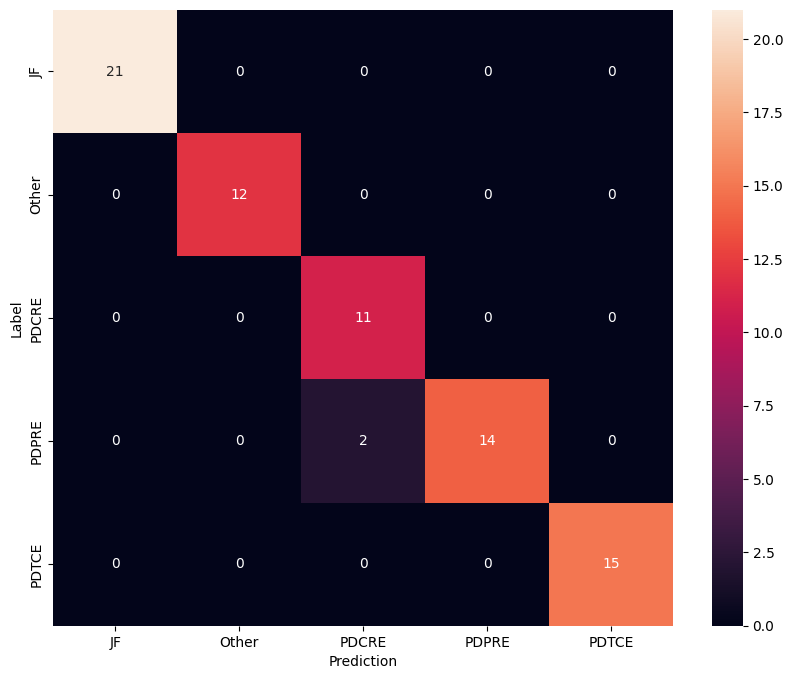

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classes,
            yticklabels=classes,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('confusionc5.png', bbox_inches='tight')
plt.show()

In [47]:
# This option is for a fully-quantized model for the Coral.AI USB accelerator
if 0:
    print("Create representative dataset for quantization")
    #def representative_dataset():
    #  for data in tf.data.Dataset.from_tensor_slices((train_spectrogram_ds)).batch(1).take(32):
    #    yield [tf.dtypes.cast(data, tf.float32)]
    
    def representative_dataset():
        for _ in range(100):
          data = np.random.rand(1, 517, 513, 1)
          yield [data.astype(np.float32)]
    #for images, _ in train_spectrogram_ds.batch(1).take(100):
    #  break
    #def representative_dataset(images):
    #  for data in tf.data.Dataset.from_tensor_slices(images):
    #    yield [tf.dtypes.cast(data, tf.float32)]      

In [48]:
# This option is for a fully-quantized model for the Coral.AI USB accelerator
if 0:
    # Save model as tflite
    model_path = 'pdqc5.tflite'
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    print('Adding necessary optimizations for use on Coral.AI board')
    print('See: https://www.tensorflow.org/lite/performance/post_training_quantization')
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8  # or tf.uint8
    converter.inference_output_type = tf.uint8  # or tf.uint8
    tflite_quant_model = converter.convert()
    open(model_path, "wb").write(tflite_quant_model)
    print('model written')

# Un-quantized tflite model shows better inference performance
if 1:
    # Save model as tflite
    model_path = 'pdc5.tflite'
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_quant_model = converter.convert()
    open(model_path, "wb").write(tflite_quant_model)
    print('model written')


INFO:tensorflow:Assets written to: C:\Users\fredp\AppData\Local\Temp\tmpk6apj_wv\assets


INFO:tensorflow:Assets written to: C:\Users\fredp\AppData\Local\Temp\tmpk6apj_wv\assets


model written
